In [ ]:
!pip install  lightning-bolts==0.6.0.post1
!pip install  lightning-lite==1.8.0
!pip install  lightning-utilities==0.3.0
!pip install  pytorch-lightning==1.8.0

In [ ]:
!pip install torch==1.13.0

In [ ]:
%pip install torch==1.13.1+cu117 torchvision==0.14.1+cu117 torchtext==0.14.1 torchaudio==0.13.1 torchdata==0.5.1 --extra-index-url https://download.pytorch.org/whl/cu117

In [4]:
import torch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

In [5]:
import pytorch_lightning as pl
#import  pl_bolts
from torch import nn
from torch.nn import functional as F
from pl_bolts.models.autoencoders.components import (
    resnet18_decoder,
    resnet18_encoder,
)

class VAE(pl.LightningModule):
    def __init__(self, enc_out_dim=512, latent_dim=256, input_height=32):
        super().__init__()

        self.save_hyperparameters()

        # encoder, decoder
        #self.pre_conv = nn.Conv2d(1,3,3, padding=3)
        self.encoder = resnet18_encoder(False, False)
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim, 
            input_height=input_height, 
            first_conv=False, 
            maxpool1=False
        )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)
        self.one_hot_linear = nn.Linear(10,3072)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def gaussian_likelihood(self, mean, logscale, sample):
        scale = torch.exp(logscale)
        dist = torch.distributions.Normal(mean, scale)
        #print("sample", sample.shape)
        log_pxz = dist.log_prob(sample)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def training_step(self, batch, batch_idx):
        x, label = batch
        #print(batch)
        x, label = x.to(device), label.to(device)
        x = F.interpolate(x, size=32)
        #x = self.pre_conv(x)
        
        #print(x.shape)
        # encode x to get the mu and variance parameters
        label_one_hot = F.one_hot(label, num_classes=10)
        label_one_hot = label_one_hot.to(device)
        label_one_hot = label_one_hot.to(torch.float32)
        label_high  =self.one_hot_linear(label_one_hot)
        label_high = label_high.view_as(x)
        #print("label_high",label_high)
        #print("x", x)
        x = x + label_high
        #print("x",x, x.shape)
        x_encoded = self.encoder(x)
        #print("x_encoded", x_encoded, x_encoded.shape)
        #print("x_snc", x_encoded.shape)


        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)
        #print("myu", mu.shape, log_var.shape)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()
        #print("z",z.shape)

        # decoded 
        x_hat = vae.decoder(z)
        #print("dec", x_hat.shape)

        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - recon_loss)
        elbo = elbo.mean()

        self.log_dict({
            'elbo': elbo,
            'kl': kl.mean(),
            'recon_loss': recon_loss.mean(), 
            'reconstruction': recon_loss.mean(),
            'kl': kl.mean(),
        })

        return elbo

/usr/local/lib/python3.10/dist-packages/pl_bolts/callbacks/data_monitor.py:20: UnderReviewWarning: The feature warn_missing_pkg is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  warn_missing_pkg("wandb")
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:35: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervi

In [6]:
from torchvision import transforms
train_transforms =  transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda image: torch.stack([torch.squeeze(image,0)]*3))
])
val_transforms =  transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda image:  torch.stack([torch.squeeze(image,0)]*3))
])
test_transforms =  transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda image: torch.stack([torch.squeeze(image,0)]*3))
])
from pl_bolts.datamodules import MNISTDataModule

datamodule = MNISTDataModule('.', pin_memory=True, batch_size=32,train_transforms = train_transforms, test_transforms=test_transforms, val_transforms=val_transforms)

In [7]:
pl.seed_everything(1234)
import torch
vae = VAE().to(device)
trainer = pl.Trainer(gpus=1, max_epochs=30, accelerator = 'cuda')
trainer.fit(vae, datamodule)

INFO:lightning_lite.utilities.seed:Global seed set to 1234
<ipython-input-5-52f99c78c183>:18: UnderReviewWarning: The feature resnet18_encoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  self.encoder = resnet18_encoder(False, False)
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/autoencoders/components.py:334: UnderReviewWarning: The feature ResNetEncoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  return ResNetEncoder(EncoderBlock, [2, 2, 2, 2], first_conv, maxpool1)
/usr/local/lib/python3.10/dist-packa

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params
-------------------------------------------------
0 | encoder        | ResNetEncoder | 11.2 M
1 | decoder        | ResNetDecoder | 8.6 M 
2 | fc_mu          | Linear        | 131 K 
3 | fc_var         | Linear        | 131 K 
4 | one_hot_linear | Linear        | 33.8 K
-------------------------------------------------
20.1 M    Trainable params
0         Non-trainable params
20.1 M    Total params
80.364    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd

transform = transforms.Compose(
[transforms.ToTensor(),
 transforms.Lambda(lambda image:  torch.stack([torch.squeeze(image,0)]*3))])

mnistTest = torchvision.datasets.MNIST(root='./data', train=False,
                                    download=True, transform=transform)
mnistTestLoader = torch.utils.data.DataLoader(mnistTest, batch_size=1,
                                      shuffle=True, num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



torch.Size([25, 3, 32, 32])
torch.Size([3, 138, 274])


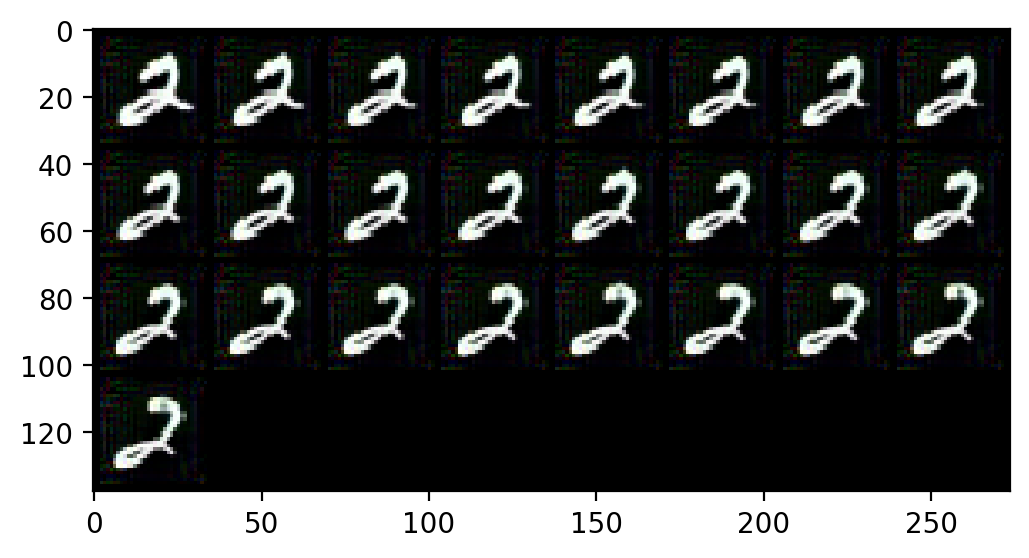

In [12]:
from matplotlib.pyplot import imshow, figure
import numpy as np
from torchvision.utils import make_grid
#from pl_bolts.transforms.dataset_normalizations import cifar10_normalization
figure(figsize=(8, 3), dpi=200)
in_image = datamodule.dataset_val.dataset[5][0].unsqueeze(0)
in_image = F.interpolate(in_image, size=32)
#pre = vae.pre_conv(torch.unsqueeze(datamodule.dataset_val.dataset[5][0],0))
pre = in_image
#normalize = cifar10_normalization()
#mean, st_d = np.array(normalize.mean), np.array(normalize.std)
batch_tensor = []
for label in np.repeat(5,25):

    label_one_hot = F.one_hot(torch.tensor(label), num_classes=10)
   # label_one_hot = label_one_hot.to(device)
    label_one_hot = label_one_hot.to(torch.float32)
    label_high  =vae.one_hot_linear(label_one_hot)
    label_high = label_high.view_as(pre)
    pre = pre + label_high
    out = vae.encoder(pre)
    mu, log_var = vae.fc_mu(out), vae.fc_var(out)

    # sample z from q
    std = torch.exp(log_var / 2)
    q = torch.distributions.Normal(mu, std)
    z = q.rsample()

    # decoded 
    out_image = vae.decoder(z)
    #print(out_image.shape)
    batch_tensor.append(torch.squeeze(out_image))
batch_tensor = torch.stack(batch_tensor)
print(batch_tensor.shape)
grid_img = make_grid(batch_tensor, n_rows=5, n_cols=5)
print(grid_img.shape)
    


#normalize = cifar10_normalization()
#mean, std = np.array(normalize.mean), np.array(normalize.std)
#img = torch.squeeze(out_image).permute(1, 2, 0).detach().cpu().numpy()# * std + mean
#in_img = in_image.permute(1, 2, 0).detach().numpy() #* std + mean

# PLOT IMAGES
#imshow(img);
#imshow(in_image.permute(1,2,0));
imshow(grid_img.permute(1, 2, 0).detach().cpu().numpy())
#datamodule.dataset_val.dataset[0]

(<matplotlib.image.AxesImage at 0x7febc058bdf0>, 2)

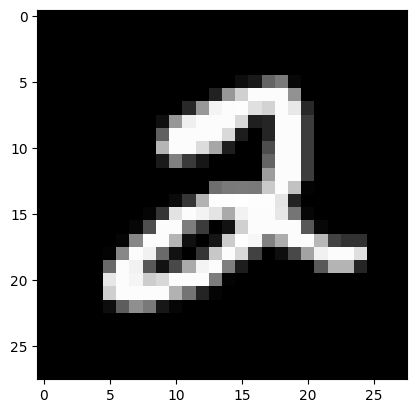

In [13]:
imshow(datamodule.dataset_val.dataset[5][0].permute(1,2,0).numpy()), datamodule.dataset_val.dataset[5][1]